In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import requests
from coordinate_scraper import CoordScraper
from data_formatting import DataFormatter

In [2]:
formatter = DataFormatter('scraped_20220714.csv')

In [3]:
formatter.run_formatting(train=True)

Finding Coordinated for Missing Postcodes


0it [00:00, ?it/s]

In [4]:
formatter.train_data.isna().sum()

source       0
city         0
postcode     0
type         0
price        0
surface      0
rooms        0
latitude     0
longitude    0
postType     0
dtype: int64

In [7]:
formatter.save_data()

In [47]:
import pandas as pd
import numpy as np
from coordinate_scraper import CoordScraper
import re

def format_postcode(x):
    x = x.split(' ')
    if len(x) > 1:
        x = ''.join(x[:2])
    else:
        x = x[0]
    if len(x) > 6:
        x = x[:4]
    if x[:4].isnumeric():
        return x
    else:
        return None

def format_priceranges(x):
    if ' to ' in x:
        x = x.split('to')
        n1 = float(re.sub("[^\\d.]","",x[0]))
        n2 = float(re.sub("[^\\d.]","",x[1]))
        return str((n1+n2)/2)
    if ' - ' in x:
        x = x.split('-')
        n1 = float(re.sub("[^\\d.]","",x[0]))
        n2 = float(re.sub("[^\\d.]","",x[1]))
        return str((n1+n2)/2)
    else:
        return x

def format_surfranges(x):
    if ' - ' in x:
        x = x.split(' - ')
        n1 = float(re.sub("[^\\d.]","",x[0]))
        n2 = float(re.sub("[^\\d.]","",x[1]))
        return str((n1+n2)/2)
    else:
        return x

def impute_rooms(room_type_medians,x):
    if pd.isna(x.rooms):
        return room_type_medians[x.type]
    else:
        return x.rooms

class DataFormatter():
    def __init__(self,scraped_filename):
        self.data = self.prepare_raw_data(scraped_filename)
        self.train_data, self.val_data = self.train_val_split()
        self.room_type_medians = dict()
        self.trained = False

    def run_formatting(self,train):
        if train:
            self.train_data = self.format_data(self.train_data,min_price=100,train=True)
        else:
            self.val_data = self.format_data(self.val_data,min_price=100,train=True)
    
    def train_val_split(self):
        #TODO
        return self.data.copy(), pd.DataFrame(columns=self.data.columns).copy()

    def generate_room_type_medians(self):
        self.room_type_medians = self.train_data.groupby('type')['rooms'].median()

    def prepare_raw_data(self,scraped_filename):
        try:
            scraped = pd.read_csv(f'./data/{scraped_filename}')
        except FileNotFoundError as e:
            print('Scraped file does not exist.')
        rentkagg = pd.read_json('./data/properties.json',lines=True)
        buykagg = pd.read_csv('./data/HousingPrices-Amsterdam-August-2021.csv')
        
        cities = ['amsterdam', 'amstelveen', 'diemen', 'zaandam', 'haarlem', 'weesp', 'ouderkerk-aan-de-amstel',
            'ouder-amstel','uithoorn','aalsmeer','haarlemmermeer',
            'duivendrecht','hoofddorp','nieuw-vennep','badhoevedorp',
            'ruigoord','zwanenburg','lijnen','de-liede']

        rentkagg = rentkagg[['areaSqm','city','furnish','latitude','longitude','postalCode','propertyType','rent','source','matchCapacity']]
        rentkagg = rentkagg[rentkagg.city.str.lower().isin(cities)]
        rentkagg = rentkagg.rename(columns={
                'areaSqm' : 'surface',
                'rent': 'price',
                'furnish': 'furnished',
                'postalCode': 'postcode',
                'propertyType': 'type',
                'matchCapacity': 'rooms'
            })
        rentkagg['postType'] = 'Rent'

        buykagg = buykagg.rename(columns={
            'Area' : 'surface',
            'Price': 'price',
            'Zip': 'postcode',
            'Room': 'rooms',
            'Lon': 'longitude',
            'Lat': 'latitude'
        })
        buykagg['source'] = 'Pararius'
        buykagg['type'] = 'house'
        buykagg['postType'] = 'Buy'
        buykagg['city'] = 'amsterdam'
        buykagg['furnished'] = None
        buykagg.drop(columns=['Unnamed: 0','Address'],inplace=True)

        data = pd.concat([scraped,rentkagg,buykagg]).reset_index(drop=True).drop_duplicates()
        return data

    def format_data(self,data,min_price=100,train=True):
        if not train and not self.trained:
            print('Train data not yet formatted. Aborting.')
            return None

        data['type'] = data['type'].str.replace(' - ','').str.strip().str.lower()
        data['type'] = data['type'].replace('anti-squat','apartment')
        data['type'] = data['type'].replace('student residence','apartment')
        data['type'] = data['type'].replace('appartement','apartment')
        data['type'] = data['type'].replace('appartment','apartment')
        data['type'] = data['type'].replace('project:','apartment')
        data['type'] = data['type'].replace('huis','house')

        data['rooms'] = data['rooms'].replace('Not important',None)
        data['rooms'] = data['rooms'].str.replace("[^\\d]","",regex=True).astype('float')

        if train:
            self.generate_room_type_medians()

        data['rooms'] = data.apply(lambda x: impute_rooms(self.room_type_medians,x),axis=1)

        data['postcode'] = data['postcode'].apply(format_postcode)

        data['price'] = data['price'].astype('str').str.replace('.0','',regex=False).str.replace(',-','',regex=False).str.replace('.','',regex=False).str.replace('k.k.','',regex=False)
        data['price'] = data['price'].apply(format_priceranges).str.replace("[^\\d.]","",regex=True).replace('',None).astype('float')

        data = data.dropna(subset=['price','postcode'])

        data = data[data['price'] > min_price].reset_index(drop=True)

        data['surface'] = data['surface'].astype('str').apply(format_surfranges).str.replace(',','').str.replace('m2','').str.replace('m²','').str.strip().astype(float)

        data = data.dropna(subset=['surface'])

        data['source'] = data['source'].str.lower()
        data['city'] = data['city'].str.lower()

        data = data.drop(columns=['furnished'])

        coordscraper = CoordScraper()
        data['latitude'] = np.nan
        data['longitude'] = np.nan

        coordmap = coordscraper.known_coords.copy()
        coordmap.set_index('postcode',inplace=True)

        data.loc[data.latitude.isna(),'latitude'] = data[data.latitude.isna()].postcode.map(dict(coordmap.latitude))
        data.loc[data.longitude.isna(),'longitude'] = data[data.longitude.isna()].postcode.map(dict(coordmap.longitude))

        print('Finding Coordinated for missing Postcodes')
        coordscraper.get_coordinates(data[data['latitude'].isna()][['postcode','city','latitude','longitude']].drop_duplicates())
        #coordscraper.save_new_coords()

        coordmap = coordscraper.known_coords.copy()
        coordmap.set_index('postcode',inplace=True)
        data.loc[data.latitude.isna(),'latitude'] = data[data.latitude.isna()].postcode.map(dict(coordmap.latitude))
        data.loc[data.longitude.isna(),'longitude'] = data[data.longitude.isna()].postcode.map(dict(coordmap.longitude))

        if train:
            self.trained = True

        return data

    def save_data(self):
        self.train_data.to_csv('./data/formatted_train_data.csv',index=False)
        self.train_data.to_csv('./data/formatted_val_data.csv',index=False)


In [48]:
f = DataFormatter('scraped_20220714.csv')

In [49]:
f.run_formatting(train=True)

Finding Coordinated for missing Postcodes


0it [00:00, ?it/s]

In [46]:
f.data[f.data['surface']=='50 - 122 m²']

,source,city,postcode,type,price,surface,rooms,furnished,latitude,longitude,postType
3301,Pararius,amsterdam,Amsterdam (Slotervaart Noord),Project:,€ 375.000 - € 700.000 v.o.n.,50 - 122 m²,1 - 4 kamers,NaN,NaN,NaN,Buy


In [50]:
f.train_data.isna().sum()

source       0
city         0
postcode     0
type         0
price        0
surface      0
rooms        0
latitude     0
longitude    0
postType     0
dtype: int64

In [51]:
f.train_data

,source,city,postcode,type,price,surface,rooms,latitude,longitude,postType
0,kamernet,amsterdam,1103SE,apartment,3120.0,120.0,3.0,52.322157,4.981185,Rent
1,kamernet,amsterdam,1103TV,room,675.0,12.0,1.0,52.322841,4.975622,Rent
2,kamernet,amsterdam,1073ST,apartment,1495.0,45.0,1.0,52.352476,4.902164,Rent
3,kamernet,amsterdam,1106AG,room,425.0,10.0,1.0,52.297942,4.974682,Rent
4,kamernet,amsterdam,1065LW,apartment,1100.0,55.0,3.0,52.356471,4.820362,Rent
...,...,...,...,...,...,...,...,...,...,...
27257,pararius,amsterdam,1097AE,house,750000.0,117.0,5.0,52.352999,4.924119,Buy
27258,pararius,amsterdam,1033CP,house,350000.0,72.0,5.0,52.414054,4.891716,Buy
27259,pararius,amsterdam,1058AK,house,350000.0,51.0,5.0,52.363499,4.856891,Buy
27260,pararius,amsterdam,1095MB,house,599000.0,113.0,5.0,52.375095,4.966041,Buy


In [53]:
f.save_data()

# Join Data 

In [15]:
scraped = pd.read_csv('./data/scraped_20220714.csv')

In [16]:
cities = ['amsterdam', 'amstelveen', 'diemen', 'zaandam', 'haarlem', 'weesp', 'ouderkerk-aan-de-amstel',
         'ouder-amstel','uithoorn','aalsmeer','haarlemmermeer',
         'duivendrecht','hoofddorp','nieuw-vennep','badhoevedorp',
         'ruigoord','zwanenburg','lijnen','de-liede']

In [17]:
rentkagg = pd.read_json('./data/properties.json',lines=True)

In [18]:
rentkagg = rentkagg[['areaSqm','city','furnish','latitude','longitude','postalCode','propertyType','rent','source','matchCapacity']]

In [19]:
rentkagg = rentkagg[rentkagg.city.str.lower().isin(cities)]

In [20]:
rentkagg = rentkagg.rename(columns={
    'areaSqm' : 'surface',
    'rent': 'price',
    'furnish': 'furnished',
    'postalCode': 'postcode',
    'propertyType': 'type',
    'matchCapacity': 'rooms'
})

In [21]:
rentkagg['postType'] = 'Rent'

In [22]:
buykagg = pd.read_csv('./data/HousingPrices-Amsterdam-August-2021.csv')

In [23]:
buykagg = buykagg.rename(columns={
    'Area' : 'surface',
    'Price': 'price',
    'Zip': 'postcode',
    'Room': 'rooms',
    'Lon': 'longitude',
    'Lat': 'latitude'
})

In [24]:
buykagg['source'] = 'Pararius'
buykagg['type'] = 'house'
buykagg['postType'] = 'Buy'
buykagg['city'] = 'amsterdam'
buykagg['furnished'] = None

In [25]:
buykagg.drop(columns=['Unnamed: 0','Address'],inplace=True)

In [26]:
data = pd.concat([scraped,rentkagg,buykagg]).reset_index(drop=True).drop_duplicates()

In [30]:
len(data)

27322

# Format Data

In [104]:
data['type'].unique()

array([' - Apartment ', ' - Room ', ' - Studio ', 'House', 'Appartment',
       'Apartment', 'Studio', 'Room', 'Appartement', 'Project:', 'Huis',
       ' - Anti-squat ', 'Anti-squat', 'Student residence', 'house'],
      dtype=object)

In [105]:
data['type'] = data['type'].str.replace(' - ','').str.strip().str.lower()
data['type'] = data['type'].replace('anti-squat','apartment')
data['type'] = data['type'].replace('student residence','apartment')
data['type'] = data['type'].replace('appartement','apartment')
data['type'] = data['type'].replace('appartment','apartment')
data['type'] = data['type'].replace('project:','apartment')
data['type'] = data['type'].replace('huis','house')

In [106]:
def format_postcode(x):
    x = x.split(' ')
    if len(x) > 1:
        x = ''.join(x[:2])
    else:
        x = x[0]
    if len(x) > 6:
        x = x[:4]
    if x[:4].isnumeric():
        return x
    else:
        return None

In [107]:
data['postcode'] = data['postcode'].apply(format_postcode)

In [108]:
def format_priceranges(x):
    if ' to ' in x:
        x = x.split('to')
        n1 = float(re.sub("[^\\d.]","",x[0]))
        n2 = float(re.sub("[^\\d.]","",x[1]))
        return str((n1+n2)/2)
    if ' - ' in x:
        x = x.split('-')
        n1 = float(re.sub("[^\\d.]","",x[0]))
        n2 = float(re.sub("[^\\d.]","",x[1]))
        return str((n1+n2)/2)
    else:
        return x

In [109]:
data['price'] = data['price'].astype('str').str.replace('.0','',regex=False).str.replace(',-','',regex=False).str.replace('.','',regex=False).str.replace('k.k.','',regex=False)

In [110]:
data['price'] = data['price'].apply(format_priceranges).str.replace("[^\\d.]","",regex=True).replace('',None).astype('float')

In [111]:
data = data.dropna(subset=['price','postcode'])

In [112]:
data = data[data['price'] > 100].reset_index(drop=True)

In [113]:
def format_surfranges(x):
    if ' - ' in x:
        x = x.split(' - ')
        n1 = float(re.sub("[^\\d.]","",x[0]))
        n2 = float(re.sub("[^\\d.]","",x[1]))
        return str((n1+n2)/2)
    else:
        return x

In [114]:
data['surface'] = data['surface'].astype('str').apply(format_surfranges).str.replace(',','').str.replace('m2','').str.replace('m²','').str.strip().astype(float)

In [115]:
data['rooms'] = data['rooms'].replace('Not important',None)

In [116]:
data['rooms'] = data['rooms'].str.replace("[^\\d]","",regex=True).astype('float')

In [117]:
type_medians = data.groupby('type')['rooms'].median()
def impute_rooms(x):
    if pd.isna(x.rooms):
        return type_medians[x.type]
    else:
        return x.rooms

In [118]:
data['rooms'] = data.apply(impute_rooms,axis=1)

In [119]:
data = data.dropna(subset=['surface','price'])

In [120]:
data['source'] = data['source'].str.lower()
data['city'] = data['city'].str.lower()

In [121]:
data = data.drop(columns=['furnished'])

In [122]:
coordscraper = CoordScraper()

In [123]:
coordscraper.known_coords

,postcode,latitude,longitude
0,1103SE,52.322157,4.981185
1,1103TV,52.322841,4.975622
2,1073ST,52.352476,4.902164
3,1106AG,52.297942,4.974682
4,1065LW,52.356471,4.820362
...,...,...,...
9518,1502NC,52.449858,4.823248
9519,2012NJ,52.370877,4.623300
9520,1098BJ,52.356611,4.934136
9521,1078VX,52.343424,4.893527


In [124]:
data['latitude'] = np.nan
data['longitude'] = np.nan

In [125]:
coordmap = coordscraper.known_coords.copy()
coordmap.set_index('postcode',inplace=True)

In [126]:
data.loc[data.latitude.isna(),'latitude'] = data[data.latitude.isna()].postcode.map(dict(coordmap.latitude))
data.loc[data.longitude.isna(),'longitude'] = data[data.longitude.isna()].postcode.map(dict(coordmap.longitude))

In [127]:
coordscraper.get_coordinates(data[data['latitude'].isna()][['postcode','city','latitude','longitude']].drop_duplicates())

0it [00:00, ?it/s]

In [128]:
coordscraper.new_coords

,postcode


In [129]:
coordscraper.save_new_coords()

Either known_coords or new_coords dataframe has incorrect schema.


In [130]:
coordmap = coordscraper.known_coords.copy()

In [131]:
coordmap.set_index('postcode',inplace=True)

In [132]:
data.loc[data.latitude.isna(),'latitude'] = data[data.latitude.isna()].postcode.map(dict(coordmap.latitude))
data.loc[data.longitude.isna(),'longitude'] = data[data.longitude.isna()].postcode.map(dict(coordmap.longitude))

In [133]:
data = data.drop_duplicates()

In [134]:
data.isna().sum()

source       0
city         0
postcode     0
type         0
price        0
surface      0
rooms        0
latitude     0
longitude    0
postType     0
dtype: int64

In [135]:
data.to_csv('./data/formatted_data.csv',index=False)

In [46]:
data

,source,city,postcode,type,price,surface,rooms,latitude,longitude,postType
0,kamernet,amsterdam,1103SE,apartment,3120.0,120.0,3.0,52.322157,4.981185,Rent
1,kamernet,amsterdam,1103TV,room,675.0,12.0,1.0,52.322841,4.975622,Rent
2,kamernet,amsterdam,1073ST,apartment,1495.0,45.0,1.0,52.352476,4.902164,Rent
3,kamernet,amsterdam,1106AG,room,425.0,10.0,1.0,52.297942,4.974682,Rent
4,kamernet,amsterdam,1065LW,apartment,1100.0,55.0,3.0,52.356471,4.820362,Rent
...,...,...,...,...,...,...,...,...,...,...
26626,pararius,amsterdam,1097AE,house,750000.0,117.0,5.0,52.352999,4.924119,Buy
26627,pararius,amsterdam,1033CP,house,350000.0,72.0,5.0,52.414054,4.891716,Buy
26628,pararius,amsterdam,1058AK,house,350000.0,51.0,5.0,52.363499,4.856891,Buy
26629,pararius,amsterdam,1095MB,house,599000.0,113.0,5.0,52.375095,4.966041,Buy


In [179]:
data = pd.read_csv('prepared_amsterdam_rent.csv')

<AxesSubplot:xlabel='longitude', ylabel='price'>

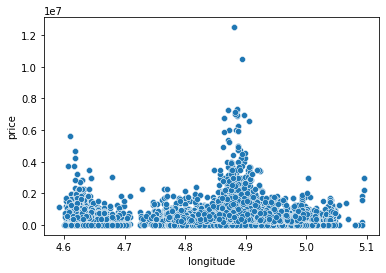

In [180]:
sns.scatterplot(data=data,x='longitude',y='price')

<AxesSubplot:xlabel='latitude', ylabel='price'>

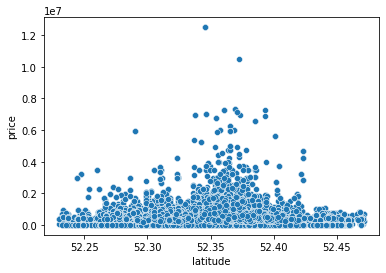

In [181]:
sns.scatterplot(data=data,x='latitude',y='price')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

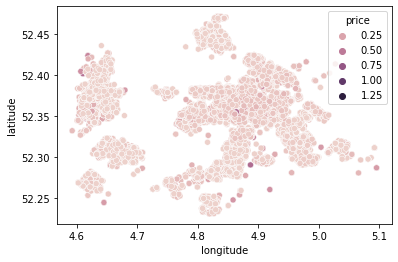

In [183]:
sns.scatterplot(data=data,x='longitude',y='latitude',hue='price')

<AxesSubplot:xlabel='rooms', ylabel='price'>

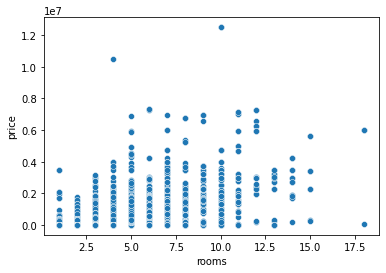

In [38]:
sns.scatterplot(data=data,x='rooms',y='price')

In [39]:
data['pps'] = data['price']/data['surface']

<AxesSubplot:xlabel='type', ylabel='pps'>

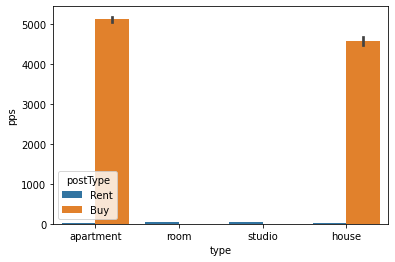

In [40]:
sns.barplot(data=data,x='type',y='pps',hue='postType')

<AxesSubplot:xlabel='surface', ylabel='price'>

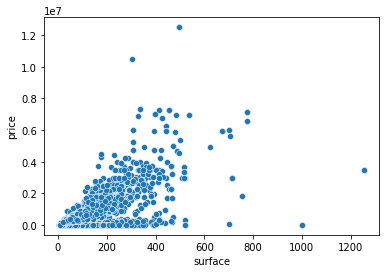

In [41]:
sns.scatterplot(data=data,x='surface',y='price')

In [65]:
data['longcat_i'] = pd.cut(data['longitude'],100,labels=list(range(100))).astype('int')
data['latcat_i'] = pd.cut(data['latitude'],100,labels=list(range(100))).astype('int')

In [70]:
data['longcat'] = pd.cut(data['longitude'],100)
data['latcat'] = pd.cut(data['latitude'],100)

In [71]:
latlng_grid = data[['latcat','longcat']].drop_duplicates()

In [78]:
latlng_grid['latitude'] = latlng_grid['latcat'].apply(lambda x: x.mid)
latlng_grid['longitude'] = latlng_grid['longcat'].apply(lambda x: x.mid)

In [80]:
latlng_grid = latlng_grid[['latitude','longitude']]

In [84]:
latlng_grid 

,latitude,longitude,resolution
0,52.3230,4.9825,100x100
1,52.3230,4.9775,100x100
2,52.3520,4.9015,100x100
3,52.2990,4.9775,100x100
4,52.3570,4.8215,100x100
...,...,...,...
24595,52.3740,4.7965,100x100
24615,52.3590,4.9775,100x100
24838,52.3495,4.8115,100x100
24858,52.3400,4.9515,100x100


In [81]:
latlng_grid['resolution'] = '100x100'

C:\Users\gx826tr\AppData\Local\Temp\ipykernel_17468\587450639.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latlng_grid['resolution'] = '100x100'


In [83]:
#latlng_grid.to_csv('./data/latlong_grid.csv',index=False)

In [43]:
data['ppaCatPerct'] = None

In [56]:
ranks = {}
for t in data.type.unique():
    for pt in data.postType.unique():
        df = data[(data['type']==t)&(data['postType']==pt)]
        if len(df) > 0:
            ranks[(t,pt)] = pd.cut(df['pps'],50,labels=list(range(50)))

In [56]:
ranks = {}
for t in data.type.unique():
    for pt in data.postType.unique():
        df = data[(data['type']==t)&(data['postType']==pt)]
        if len(df) > 0:
            ranks[(t,pt)] = df['pps'].rank()
            ranks[(t,pt)]=(ranks[(t,pt)]-ranks[(t,pt)].min())/(ranks[(t,pt)].max()-ranks[(t,pt)].min())

In [57]:
for k in ranks:
    data.loc[ranks[k].index,'ppaCatPerct'] = ranks[k]

In [58]:
data.groupby(['type','postType'])['ppaCatPerct'].mean()

type       postType
apartment  Buy         0.500000
           Rent        0.499961
house      Buy         0.500000
           Rent        0.500000
room       Rent        0.500000
studio     Rent        0.500000
Name: ppaCatPerct, dtype: float64

In [59]:
data.groupby(['latcat','longcat'])[['latitude','longitude']].mean()

latitude  longitude
latcat           longcat                            
(52.23, 52.235]  (4.592, 4.603]       NaN        NaN
                 (4.603, 4.613]       NaN        NaN
                 (4.613, 4.623]       NaN        NaN
                 (4.623, 4.633]       NaN        NaN
                 (4.633, 4.643]       NaN        NaN
...                                   ...        ...
(52.466, 52.471] (5.045, 5.055]       NaN        NaN
                 (5.055, 5.065]       NaN        NaN
                 (5.065, 5.075]       NaN        NaN
                 (5.075, 5.085]       NaN        NaN
                 (5.085, 5.095]       NaN        NaN

[2500 rows x 2 columns]

In [61]:
data

,source,city,postcode,type,price,surface,rooms,latitude,longitude,postType,pps,longcat,latcat,ppaCatPerct
0,kamernet,amsterdam,1103SE,apartment,3120.0,120.0,3.0,52.322157,4.981185,Rent,26.000000,"(4.975, 4.985]","(52.322, 52.327]",0.616498
1,kamernet,amsterdam,1103TV,room,675.0,12.0,1.0,52.322841,4.975622,Rent,56.250000,"(4.975, 4.985]","(52.322, 52.327]",0.696539
2,kamernet,amsterdam,1073ST,apartment,1495.0,45.0,1.0,52.352476,4.902164,Rent,33.222222,"(4.894, 4.904]","(52.351, 52.356]",0.87263
3,kamernet,amsterdam,1106AG,room,425.0,10.0,1.0,52.297942,4.974682,Rent,42.500000,"(4.975, 4.985]","(52.298, 52.303]",0.421404
4,kamernet,amsterdam,1065LW,apartment,1100.0,55.0,3.0,52.356471,4.820362,Rent,20.000000,"(4.814, 4.824]","(52.356, 52.36]",0.289329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24955,pararius,amsterdam,1097AE,house,750000.0,117.0,5.0,52.352999,4.924119,Buy,6410.256410,"(4.914, 4.924]","(52.351, 52.356]",0.768017
24956,pararius,amsterdam,1033CP,house,350000.0,72.0,5.0,52.414054,4.891716,Buy,4861.111111,"(4.884, 4.894]","(52.413, 52.418]",0.529362
24957,pararius,amsterdam,1058AK,house,350000.0,51.0,5.0,52.363499,4.856891,Buy,6862.745098,"(4.854, 4.864]","(52.36, 52.365]",0.80927
24958,pararius,amsterdam,1095MB,house,599000.0,113.0,5.0,52.375095,4.966041,Buy,5300.884956,"(4.965, 4.975]","(52.375, 52.38]",0.61223


<AxesSubplot:xlabel='longcat_i', ylabel='latcat_i'>

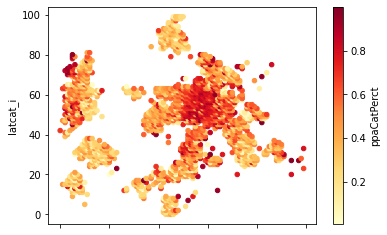

In [68]:
data.groupby(['latcat_i','longcat_i'])['ppaCatPerct'].median().reset_index().dropna().plot(x='longcat_i',y='latcat_i',kind='scatter',c='ppaCatPerct',cmap='YlOrRd')

<AxesSubplot:xlabel='longcat', ylabel='latcat'>

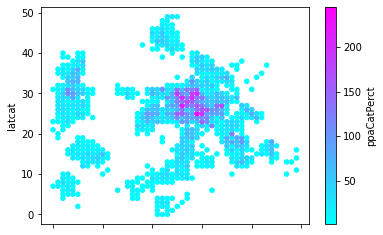

In [61]:
data.groupby(['latcat','longcat'])['ppaCatPerct'].count().reset_index().dropna().plot(x='longcat',y='latcat',kind='scatter',c='ppaCatPerct',cmap='cool')

<AxesSubplot:xlabel='type', ylabel='ppaCatPerct'>

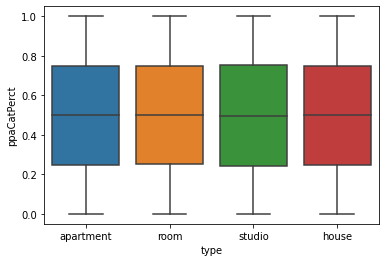

In [712]:
sns.boxplot(data=data, x='type', y='ppaCatPerct')

<AxesSubplot:xlabel='postType', ylabel='ppaCatPerct'>

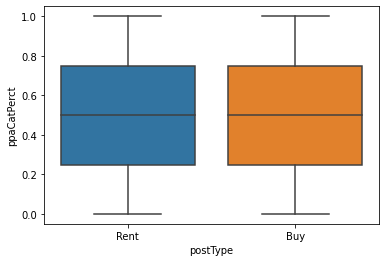

In [713]:
sns.boxplot(data=data, x='postType', y='ppaCatPerct')

<AxesSubplot:xlabel='ppaCatPerct', ylabel='Count'>

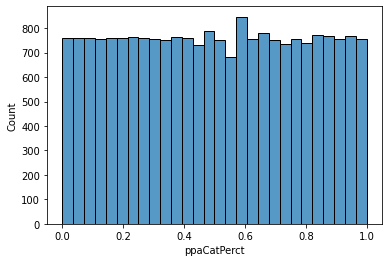

In [715]:
sns.histplot(data=data, x='ppaCatPerct')

In [184]:
data['postcode_num'] = data['postcode'].str.slice(0,4)

In [237]:
data['price_p_area'] = data['price']/data['surface']

,source,city,postcode,type,price,surface,rooms,furnished,latitude,longitude,postType
0,Kamernet,amsterdam,1103SE,apartment,"€ 3120,-",120 m2,NaN,Unfurnished,52.322159,4.981188,NaN
1,Kamernet,amsterdam,1103TV,room,"€ 675,-",12 m2,NaN,Unfurnished,52.322843,4.975625,NaN
2,Kamernet,amsterdam,1073ST,apartment,"€ 1495,-",45 m2,- 1 bedroom,Furnished,52.352478,4.902167,NaN
3,Kamernet,amsterdam,1106AG,room,"€ 425,-",10 m2,NaN,Furnished,52.297944,4.974685,NaN
4,Kamernet,amsterdam,1065LW,apartment,"€ 1100,- Utilities incl.",55 m2,NaN,Furnished,52.356473,4.820365,NaN
...,...,...,...,...,...,...,...,...,...,...,...
13043,Pararius,amsterdam,1097 AE,house,750000.0,117,1,None,52.354173,4.927757,Buy
13044,Pararius,amsterdam,1033 CP,house,350000.0,72,3,None,52.414587,4.890612,Buy
13045,Pararius,amsterdam,1058 AK,house,350000.0,51,3,None,52.363256,4.856935,Buy
13046,Pararius,amsterdam,1095 MB,house,599000.0,113,4,None,52.375268,4.965731,Buy


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

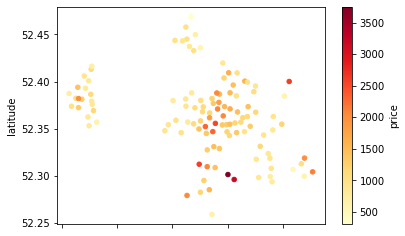

In [190]:
data.groupby('postcode_num')[['price','latitude','longitude']].mean().reset_index().plot(x='longitude',y='latitude',c='price',kind='scatter',cmap='YlOrRd')

In [192]:
data.groupby('postcode_num')[['price','latitude','longitude']].count().sort_values('price')

,price,latitude,longitude
postcode_num,,,
1384,1,1,1
1509,1,1,1
1028,1,1,1
1189,1,1,1
2019,2,2,2
...,...,...,...
1078,195,195,195
1012,197,197,197
1017,200,200,200


In [65]:
import geopandas as gpd

In [77]:
import sqlite3

In [78]:
conn = sqlite3.connect('./data/WijkBuurtkaart_2021_v1.gpkg')

In [79]:
cursor = conn.cursor()

In [88]:
cursor.execute("select name from sqlite_schema where type='table' and name not like 'sqlite_%';")

In [90]:
result = cursor.fetchall()

In [91]:
result

[('gpkg_spatial_ref_sys',),
 ('gpkg_contents',),
 ('gpkg_ogr_contents',),
 ('gpkg_geometry_columns',),
 ('gpkg_tile_matrix_set',),
 ('gpkg_tile_matrix',),
 ('gemeenten2021',),
 ('gpkg_extensions',),
 ('rtree_gemeenten2021_geom',),
 ('rtree_gemeenten2021_geom_rowid',),
 ('rtree_gemeenten2021_geom_node',),
 ('rtree_gemeenten2021_geom_parent',),
 ('cbs_wijken_2021',),
 ('rtree_cbs_wijken_2021_geom',),
 ('rtree_cbs_wijken_2021_geom_rowid',),
 ('rtree_cbs_wijken_2021_geom_node',),
 ('rtree_cbs_wijken_2021_geom_parent',),
 ('cbs_buurten_2021',),
 ('rtree_cbs_buurten_2021_geom',),
 ('rtree_cbs_buurten_2021_geom_rowid',),
 ('rtree_cbs_buurten_2021_geom_node',),
 ('rtree_cbs_buurten_2021_geom_parent',)]

In [98]:
buurten = gpd.read_file('./data/WijkBuurtkaart_2021_v1.gpkg',layer='cbs_buurten_2021')

In [103]:
wijken = gpd.read_file('./data/WijkBuurtkaart_2021_v1.gpkg',layer='cbs_wijken_2021')

In [361]:
gpd.read_file('./data/WijkBuurtkaart_2021_v1.gpkg',layer='gemeenten2021')

,gemeentecode,gemeentenaam,water,omgevingsadressendichtheid,stedelijkheid_adressen_per_km2,bevolkingsdichtheid_inwoners_per_km2,aantal_inwoners,mannen,vrouwen,percentage_personen_0_tot_15_jaar,...,percentage_uit_nederlandse_antillen_en_aruba,percentage_uit_suriname,percentage_uit_turkije,percentage_overige_nietwestersemigratieachtergrond,oppervlakte_totaal_in_ha,oppervlakte_land_in_ha,oppervlakte_water_in_ha,jaarstatcode,jaar,geometry
0,GM0034,Almere,JA,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,...,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,2021GM0034,2021,"MULTIPOLYGON (((150213.998 479503.726, 150087...."
1,GM0050,Zeewolde,JA,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,...,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,2021GM0050,2021,"MULTIPOLYGON (((170588.413 486792.192, 170570...."
2,GM0060,Ameland,JA,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,...,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,2021GM0060,2021,"MULTIPOLYGON (((196000.000 610000.000, 196000...."
3,GM0072,Harlingen,JA,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,...,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,2021GM0072,2021,"MULTIPOLYGON (((158392.775 580357.500, 158387...."
4,GM0088,Schiermonnikoog,JA,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,...,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,2021GM0088,2021,"MULTIPOLYGON (((219000.000 616567.418, 219000...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,GM1966,Het Hogeland,NEE,414,5,99,47834,24052,23782,15,...,0,0,0,3,90308,48249,42059,2021GM1966,2021,"MULTIPOLYGON (((217037.735 601967.991, 217043...."
431,GM1969,Westerkwartier,NEE,476,5,176,63678,32034,31644,17,...,0,0,0,3,36887,36269,618,2021GM1969,2021,"MULTIPOLYGON (((215186.661 595044.495, 215190...."
432,GM1970,Noardeast-Fryslân,NEE,463,5,120,45481,22879,22602,17,...,0,0,0,2,51645,37783,13862,2021GM1970,2021,"MULTIPOLYGON (((207769.575 603284.528, 207773...."
433,GM1978,Molenlanden,NEE,393,5,243,44130,22317,21813,18,...,0,0,0,2,19158,18173,986,2021GM1978,2021,"MULTIPOLYGON (((123569.533 440132.167, 123576...."


In [104]:
buurten[buurten['gemeentenaam']=='Haarlem']

,buurtcode,buurtnaam,wijkcode,gemeentecode,gemeentenaam,indelingswijziging_wijken_en_buurten,water,meest_voorkomende_postcode,dekkingspercentage,omgevingsadressendichtheid,...,percentage_uit_nederlandse_antillen_en_aruba,percentage_uit_suriname,percentage_uit_turkije,percentage_overige_nietwestersemigratieachtergrond,oppervlakte_totaal_in_ha,oppervlakte_land_in_ha,oppervlakte_water_in_ha,jaarstatcode,jaar,geometry
4809,BU03920101,Stationsbuurt,WK039201,GM0392,Haarlem,1,NEE,2011,1,5056,...,0,1,1,9,51,46,5,2021BU03920101,2021,"MULTIPOLYGON (((103889.258 489415.316, 103917...."
4810,BU03920102,Binnenstad,WK039201,GM0392,Haarlem,1,NEE,2011,1,5838,...,0,1,1,8,27,26,1,2021BU03920102,2021,"MULTIPOLYGON (((103862.446 488835.233, 103859...."
4811,BU03920103,Bakenes,WK039201,GM0392,Haarlem,1,NEE,2011,1,5561,...,0,1,1,7,25,23,2,2021BU03920103,2021,"MULTIPOLYGON (((104227.761 488779.744, 104286...."
4812,BU03920104,Burgwal,WK039201,GM0392,Haarlem,1,NEE,2011,1,5578,...,0,1,2,6,21,18,3,2021BU03920104,2021,"MULTIPOLYGON (((104320.656 488719.022, 104381...."
4813,BU03920105,Vijfhoek,WK039201,GM0392,Haarlem,1,NEE,2011,1,5589,...,0,1,1,7,25,24,1,2021BU03920105,2021,"MULTIPOLYGON (((103414.654 488532.250, 103437...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,BU03922103,Nobelprijsbuurt,WK039221,GM0392,Haarlem,1,NEE,2037,1,2789,...,0,2,14,13,24,24,0,2021BU03922103,2021,"MULTIPOLYGON (((105824.295 486100.323, 105840...."
4916,BU03922104,Poelpolder-zuid,WK039221,GM0392,Haarlem,1,NEE,2037,1,1548,...,-99999999,-99999999,-99999999,-99999999,47,42,5,2021BU03922104,2021,"MULTIPOLYGON (((106011.254 486097.833, 106066...."
4917,BU03922105,Archimedesbuurt,WK039221,GM0392,Haarlem,1,NEE,2037,1,3614,...,0,3,14,18,16,16,0,2021BU03922105,2021,"MULTIPOLYGON (((105527.148 485752.969, 105696...."
4918,BU03922106,Erasmusbuurt,WK039221,GM0392,Haarlem,1,NEE,2037,2,3152,...,0,3,10,18,20,20,0,2021BU03922106,2021,"MULTIPOLYGON (((105769.564 485484.581, 105781...."


In [108]:
wijken[wijken['gemeentenaam']=='Diemen']

,wijkcode,wijknaam,gemeentecode,gemeentenaam,indelingswijziging_wijken_en_buurten,water,omgevingsadressendichtheid,stedelijkheid_adressen_per_km2,bevolkingsdichtheid_inwoners_per_km2,aantal_inwoners,...,percentage_uit_nederlandse_antillen_en_aruba,percentage_uit_suriname,percentage_uit_turkije,percentage_overige_nietwestersemigratieachtergrond,oppervlakte_totaal_in_ha,oppervlakte_land_in_ha,oppervlakte_water_in_ha,jaarstatcode,jaar,geometry
26,WK038499,,GM0384,Diemen,-99999999,JA,-99999999,-99999999,-99999999,-99999999,...,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,2021WK038499,2021,"MULTIPOLYGON (((129707.725 484199.703, 129713...."
1037,WK038401,Diemen Noord,GM0384,Diemen,1,NEE,1289,3,5148,6725,...,0,9,4,11,145,131,15,2021WK038401,2021,"MULTIPOLYGON (((126550.109 485437.801, 126590...."
1038,WK038402,Diemen Centrum,GM0384,Diemen,1,NEE,2787,1,5496,10155,...,0,6,2,16,186,185,2,2021WK038402,2021,"MULTIPOLYGON (((127558.469 483706.997, 127630...."
1039,WK038403,Diemen Zuid,GM0384,Diemen,1,NEE,3434,1,6958,7470,...,0,9,4,14,112,107,4,2021WK038403,2021,"MULTIPOLYGON (((125542.129 483557.453, 125916...."
1040,WK038404,Bergwijkpark,GM0384,Diemen,1,NEE,3962,1,-99999999,0,...,-99999999,-99999999,-99999999,-99999999,21,21,0,2021WK038404,2021,"MULTIPOLYGON (((125437.747 482292.417, 125437...."
1041,WK038405,Holland Park,GM0384,Diemen,1,NEE,3715,1,9472,4590,...,2,8,2,27,48,48,0,2021WK038405,2021,"MULTIPOLYGON (((126297.418 482421.131, 126603...."
1042,WK038406,Bedrijventerreinen,GM0384,Diemen,1,NEE,2410,2,70,55,...,-99999999,-99999999,-99999999,-99999999,81,79,2,2021WK038406,2021,"MULTIPOLYGON (((126367.279 483187.924, 126934...."
1043,WK038407,Plantage de Sniep,GM0384,Diemen,1,NEE,1910,2,5015,2165,...,1,11,3,10,45,43,2,2021WK038407,2021,"MULTIPOLYGON (((126937.808 482780.651, 126934...."
1044,WK038408,Buitengebied,GM0384,Diemen,1,NEE,558,4,27,160,...,0,6,0,2,654,585,68,2021WK038408,2021,"MULTIPOLYGON (((130693.744 484729.154, 130686...."
